## Baro Array - Coherence

### Importing

In [1]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy import Stream

from andbro__read_sds import __read_sds

from functions.interpolate_nan import __interpolate_nan

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Setting Variables

In [3]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

# example 1
config['tbeg'] = obspy.UTCDateTime("2024-03-16 06:00")
config['tend'] = obspy.UTCDateTime("2024-03-16 18:00")

# example 2
# config['tbeg'] = obspy.UTCDateTime("2024-03-23 06:00")
# config['tend'] = obspy.UTCDateTime("2024-03-23 17:00")

config['tbeg'] = obspy.UTCDateTime("2024-03-23 00:00")
config['tend'] = obspy.UTCDateTime("2024-03-25 00:00")

config['seeds'] = [
                   'BW.ROMY.03.LDI',
                   'BW.GELB..LDO',
                   'BW.GRMB..LDO',
                   'BW.ALFT..LDO',
                   'BW.BIB..LDO',
                   'BW.TON..LDO',
]

config['fmin'] = 0.5e-4
config['fmax'] = 0.1

config['path_to_figs'] = data_path+"/LNM2/figures/"


### Load FURT Data

In [4]:
from andbro__load_FURT_stream import __load_furt_stream

In [5]:
# furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

### Load Pressure Data

In [ ]:
df_pressure = pd.DataFrame()

st = Stream()

for _i, seed in enumerate(config['seeds']):

    if "ROMY" in seed:
        seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])
    print(ps)

    for tr in ps:
        if np.isnan(tr.data).any():
            print("-> NaN found")
            tr.data = __interpolate_nan(tr.data)

    try:
        # convert from Pa to hPa
        if "ROMY" in seed:
            ps[0].data = ps[0].data / 100

        ps = ps.detrend("simple")

        ps = ps.taper(0.01, type="cosine")

        ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

        ps = ps.resample(config['fmax']*4)

        # convert from hPa to Pa
        ps[0].data = ps[0].data * 100

        if _i == 0:
            df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

        df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

        ps.plot();

        st += ps

    except:
        print(f"Error: {seed}")


In [14]:
def __compute_baro_gradient_romy(tbeg, tend, status=False, excluded_stations=[]):

    ######################
    """
    rotation_X = -u_nz
    rotation_Y =  u_ez
    rotation_Z = 0.5*(u_ne-u_en)
    """
    ######################

    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.colors

    from obspy import UTCDateTime, Stream, read_inventory
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    if os.uname().nodename == 'lighthouse':
        root_path = '/home/andbro/'
        data_path = '/home/andbro/kilauea-data/'
        archive_path = '/home/andbro/freenas/'
        bay_path = '/home/andbro/ontap-ffb-bay200/'
        lamont_path = '/home/andbro/lamont/'
    elif os.uname().nodename == 'kilauea':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'
    elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'

    # _____________________________________________________

    # start timer for runtime
    start_timer = timeit.default_timer()

    # _____________________________________________________

    # generate configuration object
    config = {}

    # convert to utcdatetime object
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    # select the fdsn client for the stations
    # config['fdsn_client'] = {"BW":Client('http://jane'), "GR":Client('BGR')}
    config['fdsn_client'] = {"BW":Client('LMU'), "GR":Client('BGR')}

    # define output seed
    config['out_seed'] = "BW.BRMY"

    config['location'] = "00"

    # specify frequency range
    config['freq1'] = 0.1
    config['freq2'] = 0.0005
    config['apply_bandpass'] = False

    # decide if information is printed while running the code
    config['verbose'] = False

    # BRMY array information
    config['array_stations'] = [
                               'BW.ROMY.03.LDI',
                               'BW.GELB..LDO',
                               'BW.GRMB..LDO',
                               'BW.ALFT..LDO',
                               'BW.BIB..LDO',
                               'BW.TON..LDO',
                                ]

    # specify reference station
    config['reference_station'] = 'BW.ROMY'

    # exclude stations
    config['subarray_stations'] = [_sta for _sta in config['array_stations'] if _sta not in excluded_stations]

    # create subarray mask
    config['subarray_mask'] = range(len(config['subarray_stations']))

    # adr parameters
    config['vp'] = 1 # 5000 #6264. #1700
    config['vs'] = 1 # 3500 #3751. #1000
    config['sigmau'] = 1e-7 # 0.0001

    # _____________________________________________________

    def __get_inventory_and_distances(config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            loc, cha = "", "BH*"

            try:
                # load local version
                inven = read_inventory(root_path+f"Documents/ROMY/stationxml_ringlaser/station_{net}_{sta}.xml")

            except:
                inven = config['fdsn_client'][net].get_stations(
                                                                network=net,
                                                                station=sta,
                                                                channel=cha,
                                                                location=loc,
                                                                starttime=config['tbeg'],
                                                                endtime=config['tend'],
                                                                level='response'
                                                                )

            # get coordinates
            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            if sta == config['reference_station'].split(".")[1]:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            # convert unit from km to m
            coo.append([lon*1000, lat*1000, height-o_height])

        return inven, np.array(coo)

    def __check_samples_in_stream(st, config):

        Rnet, Rsta = config['reference_station'].split(".")

        Rsamples = st.select(network=Rnet, station=Rsta)[0].stats.npts

        for tr in st:
            if tr.stats.npts != Rsamples:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {Rsamples})")
                st.remove(tr)

        return st

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        coo = []

        for k, station in enumerate(config['subarray_stations']):

            net, sta, loc, cha = station.split(".")

            # loc, cha = "", "BH*"

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['verbose'] else None

            # try to get waveform data
            try:
                data = __read_sds(archive_path+"temp_archive/", station, config['tbeg'], config['tend'])

            except Exception as E:
                print(E) if config['verbose'] else None
                print(f" -> getting waveforms failed for {net}.{sta}.{loc}.{cha} ...")
                config['stations_loaded'][k] = 0
                continue

            # merge if masked
            if len(data) > 3:
                print(f" -> merging stream. Length: {len(data)} -> 3") if config['verbose'] else None
                sta.merge(method=1, fill_value="interpolate")

            # successfully obtained
            if len(data) == 3:
                print(f" -> obtained: {net}.{sta}")

            # resampling using decitmate
            stdataats = data.detrend("linear");

            # assign reference station stream
            if station == config['reference_station']:
                # ref_station = stats.copy().resample(40, no_filter=False)
                ref_station = data.copy()

            st += data

            # create station list for obtained stations
            config['subarray'].append(f"{data[0].stats.network}.{data[0].stats.station}")

            print(data)

        config['coo'] = np.array(coo)

        st.plot(equal_scale=False);

        # update subarray stations
        config['subarray_stations'] = config['subarray']

        print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['verbose'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config

    def __compute_ADR(st, config, ref_station):

        # prepare data arrays
        tsz, tsn, tse = [], [], []
        for tr in st:
            try:
                if "Z" in tr.stats.channel:
                    tsz.append(tr.data)
                elif "N" in tr.stats.channel:
                    tsn.append(tr.data)
                elif "E" in tr.stats.channel:
                    tse.append(tr.data)
            except:
                print(" -> stream data could not be appended!")

        # make sure input is array type
        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        # define array for subarray stations with linear numbering
        substations = np.arange(len(config['subarray_stations']))

        try:
            result = AA.array_rotation_strain(substations,
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['coo'],
                                              config['sigmau'],
                                             )
        except Exception as E:
            print(E)
            print("\n -> failed to compute ADR...")
            return None

        # create rotation stream and add data
        out = ref_station.copy()

        out[0].data = result['ts_w3']
        out[1].data = result['ts_w2']
        out[2].data = result['ts_w1']

        out[0].stats.channel = 'BDZ'
        out[1].stats.channel = 'BDN'
        out[2].stats.channel = 'BDE'

        out[0].stats.station = config['out_seed'].split(".")[1]
        out[1].stats.station = config['out_seed'].split(".")[1]
        out[2].stats.station = config['out_seed'].split(".")[1]

        out[0].stats.network = config['out_seed'].split(".")[0]
        out[1].stats.network = config['out_seed'].split(".")[0]
        out[2].stats.network = config['out_seed'].split(".")[0]

        out[0].stats.location = config['location']
        out[1].stats.location = config['location']
        out[2].stats.location = config['location']

        out = out.detrend('linear')

        return out

    def __adjust_time_line(st0, reference="BW.ROMY"):

        Rnet, Rsta = reference.split(".")

        ref_start = st0.select(network=Rnet, station=Rsta)[0].stats.starttime
        ref_times = st0.select(network=Rnet, station=Rsta)[0].times()

        dt = st0.select(network=Rnet, station=Rsta)[0].stats.delta

        for tr in st0:
            times = tr.times(reftime=ref_start)

            tr.data = np.interp(ref_times, times, tr.data)
            tr.stats.starttime = ref_start

        return st0

    # __________________________________________________________
    # MAIN

    # launch a times
    start_timer1 = timeit.default_timer()

    # status of stations loaded
    config['stations_loaded'] = np.ones(len(config['subarray_stations']))

    # request data for pfo array
    st, ref_station, config = __get_data(config)

    # get inventory and coordinates/distances
    inv, config['coo'] = __get_inventory_and_distances(config)

    # add placebo N component
    _st = st.copy()
    for tr in _st:
        tr.stats.channel[-1] = "N"
    st += _st.copy()

    # add placebo E component
    _st = st.copy()
    for tr in _st:
        tr.stats.channel[-1] = "E"
    st += _st.copy()

    # processing
    st = st.detrend("linear")
    st = st.detrend("demean")

    # bandpass filter
    if config['apply_bandpass']:
        st = st.taper(0.02)
        st = st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
        print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")


    # plot station coordinates for check up
    import matplotlib.pyplot as plt
    stas = []
    for tr in st:
        if tr.stats.station not in stas:
            stas.append(tr.stats.station)
    plt.figure()
    for c, s in zip(config['coo'], stas):
        print(s, c)
        plt.scatter(c[0], c[1], label=s)
        plt.legend()

    # check if enough stations for ADR are available otherwise continue
    if len(st) < 9:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    # homogenize the time line
    st = __adjust_time_line(st, reference=config['reference_station'])

    # trim to requested interval
    # st = st.trim(config['tbeg'], config['tend'])

    # check for same amount of samples
    __check_samples_in_stream(st, config)

    # compute array derived rotation (ADR)
    try:
        rot = __compute_ADR(st, config, ref_station)
    except Exception as e:
        print(e)
        return None, None

    # get mean starttime
    # tstart = [tr.stats.starttime - tbeg for tr in st]
    # for tr in rot:
    #     tr.stats.starttime = tbeg + np.mean(tstart)

    # trim to requested interval
    rot = rot.trim(config['tbeg'], config['tend'])

    # plot status of data retrieval for waveforms of array stations
    if status:

        fig, ax = plt.subplots(1, 1, figsize=(15, 5))

        cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

        ax.pcolormesh(np.array([config['stations_loaded'], np.ones(len(config['stations_loaded']))*0.5]).T, cmap=cmap, edgecolors="k", lw=0.5)

        ax.set_yticks(np.arange(0, len(config['subarray_sta']))+0.5, labels=config['subarray_sta'])

        # ax.set_xlabel("Event No.",fontsize=12)
        ax.set_xticks([])
        ax.set_xlim(0, 1)

        plt.show();

    # stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60, 2)} minutes\n")

    if status:
        return rot, config['stations_loaded']
    else:
        return rot, []

In [15]:
bgrad = __compute_baro_gradient_romy(config['tbeg'], config['tend'], status=False, excluded_stations=[])

 -> /home/andbro/freenas/temp_archive/ does not exist!


TypeError: object of type 'NoneType' has no len()

### Compute Coherence

In [7]:
from functions.coherence_multitaper_stream import __coherence_multitaper_stream
from functions.coherence_welch_stream import __coherence_welch_stream

In [8]:
twin = 6*3600 # seconds
print(twin)

nseg = st[0].stats.sampling_rate*twin
nover = 0.5*nseg

ff, coh = __coherence_welch_stream(st, st.select(station="PROMY")[0], nseg=nseg, nover=nover)

# ff, coh = __coherence_multitaper_stream(st, "BW.PROMY.03.LDI", n_win=20, time_bandwidth=10)


21600


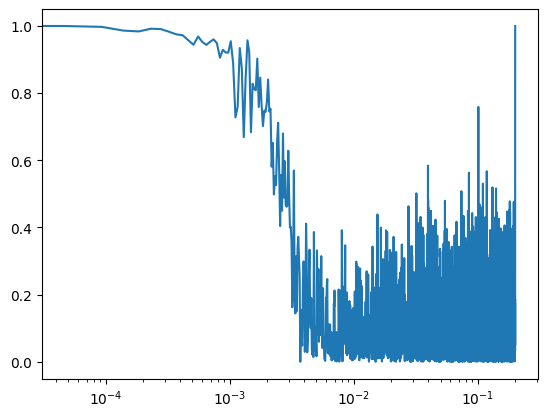

In [9]:
plt.semilogx(ff[0], coh[0])

### Compute Fband Averages

In [10]:
from functions.get_fband_average import __get_fband_average

In [11]:
ff_avg, coh_avg = [], []

for _f, _coh in zip(ff, coh):
    out = __get_fband_average(_f,
                              _coh,
                              faction_of_octave=3,
                              fmin=config['fmin'],
                              fmax=config['fmax'],
                              average='mean',
                              )

    ff_avg.append(out['fcenter'])
    coh_avg.append(out['psd_means'])


### Plotting

In [14]:
def __makeplot_coherence(st_in, ff, coh, ref, twin=None):


    st_ref = st_in.select(station=ref)

    NN = 2

    font = 12

    if st_ref[0].stats.npts*st_ref[0].stats.delta > 10000:
        time_scaling, time_unit = 1/3600, "hour"
    else:
        time_scaling, time_unit = 1/60, "min"

    fig, ax = plt.subplots(NN, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 3]})

    ax[0].plot(st_ref[0].times()*time_scaling, st_ref[0].data, color="k", label=st_ref[0].stats.station+"."+st_ref[0].stats.channel, zorder=2)

    for tr in st_in:
        ax[0].plot(tr.times()*time_scaling, tr.data, color="grey", alpha=0.5, zorder=1)


    for f, c, tr in zip(ff, coh, st_in):
        if tr.stats.station == ref:
            ax[1].plot(f, c, color="k", zorder=0, ls="-.", label=tr.stats.station+"."+tr.stats.channel)
        else:
            ax[1].plot(f, c, label=tr.stats.station+"."+tr.stats.channel, alpha=0.8)

    ax[0].legend(fontsize=font-2)
    ax[1].legend(fontsize=font-2)

    ax[1].set_xscale("log")

    ax[1].set_xlim(config['fmin'], config['fmax'])

    ax[1].grid(ls=":", color="grey", zorder=-1, which="both")

    ax[0].set_title(f"Coherence (f = {config['fmin']*1e3}-{config['fmax']*1e3}mHz | window = {twin}s)",fontsize=font+1, pad=10)
    ax[0].set_ylabel(f"Pressure (Pa)", fontsize=font)
    ax[0].set_xlabel(f"Time ({time_unit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax[1].set_ylabel(f"Coherence", fontsize=font)
    ax[1].set_xlabel(f"Frequency (Hz)", fontsize=font)

    ax[1].set_ylim(0, 1.05)

    plt.show();
    return fig

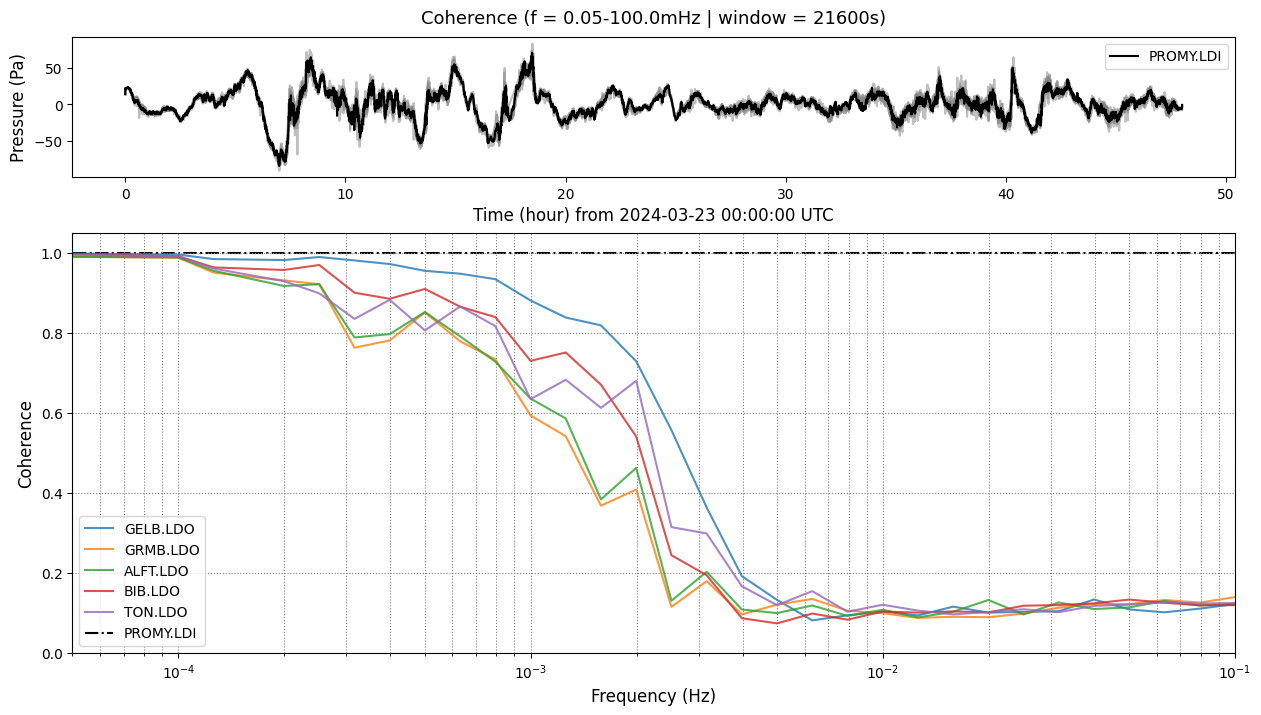

In [15]:
fig = __makeplot_coherence(st, ff_avg, coh_avg, "PROMY", twin=twin)

fig.savefig(config['path_to_figs']+f"BaroArray_Coherence_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')
